## Analysis of a ribosome profiling data using a transcriptome assembly as a reference

This analysis aims to predict novel translational events beyound protein-coding regions. However, gene annotation files from NCBI RefSeq/GenBank lack the transcription start and termination sites. To tackle this problem, we have performed _de novo_ metatranscriptome assembly using Nanopore long-read direct-RNA and Illumina short-read data [PRJNA609733](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA609733) for _Escherichia coli_ O157:H7 (ATCC 43895), _Salmonella enterica_ serovar Enteritidis (ATCC 13076), and _Listeria monocytogenes_ (ATCC 19115). We have assembled a separate _Salmonella enterica_ transcriptome using Nanopore long-read cDNA sequencing data [SRX20554650](https://www.ncbi.nlm.nih.gov/sra/SRX20554650). For ribosome profiling, we have analysed a highly phased ribosome profiling data [PRJEB51486](https://www.ebi.ac.uk/ena/browser/view/PRJEB51486) for _Salmonella enterica_ serovar Typhimurium.

### Download genomes and annotations
Follow README to create conda environment and clone the RIBOSS repository if you haven't already done so.
```
cd riboss
```

```
mkdir -p ref
cd ref

# Escherichia coli O157:H7 (ATCC 43895)
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/732/965/GCF_000732965.1_ASM73296v1/GCF_000732965.1_ASM73296v1_genomic.fna.gz
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/732/965/GCF_000732965.1_ASM73296v1/GCF_000732965.1_ASM73296v1_genomic.gff.gz

# Gram-positive Listeria monocytogenes 10403 S
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/168/695/GCF_000168695.2_ASM16869v2/GCF_000168695.2_ASM16869v2_genomic.fna.gz
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/168/695/GCF_000168695.2_ASM16869v2/GCF_000168695.2_ASM16869v2_genomic.gff.gz

# LT2
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.2_ASM694v2/GCF_000006945.2_ASM694v2_genomic.fna.gz
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.2_ASM694v2/GCF_000006945.2_ASM694v2_genomic.gff.gz

# concatenate genomes and gene annotations
for i in *.fna.gz; do \
    zcat $i;
done > metagenome.fa

for i in *.gff.gz; do \
    zcat $i \
    | gff3ToGenePred stdin stdout \
    | genePredToBed stdin stdout
done > metagenome.bed
cd ..
```

#### Download ribosome profiling and RNA-seq data ([PRJEB51486](https://www.ebi.ac.uk/ena/browser/view/PRJEB51486))

```
mkdir -p ../doc/ ../doc/styphimurium/ ../doc/styphimurium/riboseq
cd ../doc/styphimurium/riboseq

wget "https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB51486&result=read_run&fields=study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,library_strategy,library_source,fastq_ftp,submitted_ftp,sra_ftp,sample_alias,sample_title,bam_ftp&format=tsv&download=true&limit=0" -O filereport_read_run_PRJEB51486_tsv.txt

awk 'BEGIN{FS="\t"} NR>1 {print "wget -nc ftp://" $12}' filereport_read_run_PRJEB51486_tsv.txt | sh
```

#### Download Nanopore long-read direct RNA-seq and Illumina short-read RNA-seq data ([PRJNA609733](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA609733))

```
cd ../../
mkdir -p metatranscriptome
cd metatranscriptome

awk 'BEGIN{FS=","} NR>1 && !/SRR1124/ {print "prefetch",$1}' SraRunTable.csv | sh
awk 'BEGIN{FS=","} NR>1 && !/SRR1124/ {print "fasterq-dump",$1}' SraRunTable.csv | sh
gzip *.fastq

```

#### Align Nanopore long-read direct RNA-seq and Illumina short-read RNA-seq data ([PRJNA609733](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA609733))

```
# build index
cd ../../ref
bowtie2-build metagenome.fa metagenome
cd ..

# align short reads
for i in `ls ../doc/metatranscriptome/SRR1121566*.fastq.gz | sed 's/_/\t/' | awk '!seen[$1]++ {print $1}'`; do \
    bowtie2 \
    -p 8 \
    -x ../ref/metatranscriptome/metagenome \
    -1 ${i}_1.fastq.gz -2 ${i}_2.fastq.gz \
    --no-unal \
    -S ${i%%.*}.sam
done

# align long reads
for i in ../doc/metatranscriptome/SRR1121500*.fastq.gz; do \
    minimap2 -ax splice:hq -uf --sam-hit-only --MD \
    ../ref/metatranscriptome/metagenome.fa \
    $i > ${i%%.*}.sam
done

for i in ../doc/metatranscriptome/*.sam; do \
    samtools sort $i -o ${i%%.*}.bam
    samtools index ${i%%.*}.bam
    rm ${i%%.*}.sam
done
```

#### Download Nanopore cDNA sequencing data ([SRX20554650](https://www.ncbi.nlm.nih.gov/sra/SRX20554650))

```
mkdir -p ../doc/styphimurium/rnaseq/
cd ../doc/styphimurium/rnaseq/

prefetch SRR24781620
fasterq-dump SRR24781620
gzip SRR24781620.fastq
cd ../../../
```

#### Align Nanopore cDNA sequencing data ([SRX20554650](https://www.ncbi.nlm.nih.gov/sra/SRX20554650))

```
minimap2 -ax splice --sam-hit-only --MD ../ref/styphimurium/GCF_000006945.2_ASM694v2_genomic.fna.gz ../doc/styphimurium/rnaseq/SRR24781620.fastq.gz > ../doc/styphimurium/rnaseq/SRR24781620.sam
samtools sort ../doc/styphimurium/rnaseq/SRR24781620.sam -o ../doc/styphimurium/rnaseq/SRR24781620.bam
samtools index ../doc/styphimurium/rnaseq/SRR24781620.bam
```

#### GEt reads mapped to only one chromosome/contig

```
for i in *.bam; do \
    samtools view $i | cut -f1,3 | sort | uniq -c | awk 'BEGIN{OFS="\t"} {print $2,$3,$1}' \
    | cut -f1 | sort | uniq -c | awk '$1==1 {print $2}' > $i.id
    samtools view -N $i.id -o ${i%.*}.uniq.bam $i
done
```

#### Assemble transcriptome by combining Nanopore long-read direct RNA-seq and Illumina short-read RNA-seq data

In [1]:
import os
from glob import glob
from riboss.wrapper import transcriptome_assembly

superkingdom = 'Bacteria'
genome = '../ref/metatranscriptome/metagenome.fa'
strandness = 'rf'
annotation = '../ref/styphimurium/GCF_000006945.2_ASM694v2_genomic.gff.gz'
long_reads = '../doc/metatranscriptome/SRR11215003.uniq.bam'
short_reads = '../doc/metatranscriptome/SRR11215663.uniq.bam'
# long_reads = '../doc/metatranscriptome/SRR11215003.bam'
# short_reads = '../doc/metatranscriptome/SRR11215663.bam'
coverage=1
single_exon_coverage=1.5

_, _ = transcriptome_assembly(superkingdom, genome, long_reads, short_reads=short_reads, 
                              strandness=strandness, annotation=annotation, 
                              coverage=coverage, single_exon_coverage=single_exon_coverage)

INFO:root:saved StringTie GTF as ../doc/metatranscriptome/SRR11215003.uniq.gtf
INFO:root:converted transcriptome assembly to ../doc/metatranscriptome/SRR11215003.uniq.bed
INFO:root:extracted sequences to ../doc/metatranscriptome/SRR11215003.uniq.transcripts.fa


In [2]:
long_reads = '../doc/metatranscriptome/SRR11215004.uniq.bam' 
short_reads = '../doc/metatranscriptome/SRR11215664.uniq.bam'
# long_reads = '../doc/metatranscriptome/SRR11215004.bam' 
# short_reads = '../doc/metatranscriptome/SRR11215664.bam'

_, _ = transcriptome_assembly(superkingdom, genome, long_reads, short_reads=short_reads, 
                              strandness=strandness, annotation=annotation, 
                              coverage=coverage, single_exon_coverage=single_exon_coverage)

INFO:root:saved StringTie GTF as ../doc/metatranscriptome/SRR11215004.uniq.gtf
INFO:root:converted transcriptome assembly to ../doc/metatranscriptome/SRR11215004.uniq.bed
INFO:root:extracted sequences to ../doc/metatranscriptome/SRR11215004.uniq.transcripts.fa


In [3]:
long_reads = '../doc/styphimurium/rnaseq/SRR24781620.bam' 

_, _ = transcriptome_assembly(superkingdom, genome, long_reads, 
                              coverage=coverage, single_exon_coverage=single_exon_coverage)

INFO:root:saved StringTie GTF as ../doc/styphimurium/rnaseq/SRR24781620.gtf
INFO:root:converted transcriptome assembly to ../doc/styphimurium/rnaseq/SRR24781620.bed
INFO:root:extracted sequences to ../doc/styphimurium/rnaseq/SRR24781620.transcripts.fa


#### Clean up unstranded data

In [6]:
! gzip ../ref/styphimurium/GCF_000006945.2_ASM694v2_genomic.gff

In [4]:
# extract transcripts that intersect with genes on one strand only. 
! bedtools intersect \
-a ../doc/styphimurium/rnaseq/SRR24781620.bed \
-b <(zcat ../ref/styphimurium/GCF_000006945.2_ASM694v2_genomic.gff.gz | gff3ToGenePred stdin stdout | genePredToBed stdin stdout) \
-wao > ../doc/styphimurium/rnaseq/SRR24781620.txt

In [5]:
import pandas as pd
import os

wao = pd.read_csv('../doc/styphimurium/rnaseq/SRR24781620.txt', sep='\t', header=None)
wao = wao[wao[24]>0]
wao = wao[[0,2,3,4,17,6,7,8,9,10,11]].drop_duplicates().drop_duplicates([3],keep=False)
wao.rename(columns={3:'STRG',17:'Strand'}, inplace=True)
strg = pd.read_csv('../doc/styphimurium/rnaseq/SRR24781620.gtf', sep='\t', header=None, skiprows=2)
strg['STRG'] = strg[8].str.split().str[3].str.replace(r'"','').str.replace(';','')
strg = pd.merge(strg,wao[['STRG','Strand']])
strg = strg[[0,1,2,3,4,5,'Strand',7,8]]
strg.to_csv('../doc/styphimurium/rnaseq/SRR24781620.clean.gtf',sep='\t',header=None,index=None)

os.remove('../doc/styphimurium/rnaseq/SRR24781620.txt')

#### Merge transcriptomes

In [6]:
! sed -i 's/"$//;s/"gene/gene/;s/""/"/g' ../doc/styphimurium/rnaseq/SRR24781620.clean.gtf

! gunzip ../ref/styphimurium/GCF_000006945.2_ASM694v2_genomic.gff.gz
! stringtie -G ../ref/styphimurium/GCF_000006945.2_ASM694v2_genomic.gff \
--merge ../ref/styphimurium/GCF_000006945.2_ASM694v2_genomic.gff \
../doc/metatranscriptome/SRR11215003.uniq.gtf ../doc/metatranscriptome/SRR11215004.uniq.gtf ../doc/styphimurium/rnaseq/SRR24781620.clean.gtf \
| gtfToGenePred stdin stdout \
| genePredToBed stdin ../doc/metatranscriptome/metatranscriptome.bed

# extract LT2 assembled transcripts
! awk '/NC_003197.2|NC_003277.2/' ../doc/metatranscriptome/metatranscriptome.bed \
| cat <(echo 'track name="Transcriptome" description="Transcriptome assembly" visibility=2 colorByStrand="255,0,0 0,0,255"') - \
> ../doc/metatranscriptome/lt2.bed
! bedtools getfasta \
-bed ../doc/metatranscriptome/lt2.bed \
-fi ../ref/metatranscriptome/metagenome.fa -name \
-s -fo ../doc/metatranscriptome/lt2.fa

! grep -c ">" ../doc/metatranscriptome/lt2.fa

4681


#### Build STAR index for the newly assembled transcriptome

In [1]:
import os
from riboss.wrapper import build_star_index

tx_assembly =  '../doc/metatranscriptome/lt2.fa'
index = os.path.split(tx_assembly)[0] + '/' + '.'.join(os.path.split(tx_assembly)[1].split(os.extsep)[:-1])

build_star_index(tx_assembly, index)

INFO:root:renamed ../doc/metatranscriptome/lt2.fa as ../doc/metatranscriptome/lt2.original.fasta
INFO:root:cleaned up fasta headers and saved as ../doc/metatranscriptome/lt2.fa


	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode genomeGenerate --runThreadN 4 --genomeDir ../doc/metatranscriptome/lt2 --genomeFastaFiles ../doc/metatranscriptome/lt2.fa --genomeSAindexNbases 7 --genomeChrBinNbits 11
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 16 22:08:30 ..... started STAR run
Feb 16 22:08:30 ... starting to generate Genome files
Feb 16 22:08:30 ... starting to sort Suffix Array. This may take a long time...
Feb 16 22:08:30 ... sorting Suffix Array chunks and saving them to disk...
Feb 16 22:08:31 ... loading chunks from disk, packing SA...
Feb 16 22:08:32 ... finished generating suffix array
Feb 16 22:08:32 ... generating Suffix Array index
Feb 16 22:08:32 ... completed Suffix Array index
Feb 16 22:08:32 ... writing Genome to disk ...
Feb 16 22:08:32 ... writing Suffix Array to disk ...


INFO:root:saved index to ../doc/metatranscriptome/lt2


Feb 16 22:08:32 ... writing SAindex to disk
Feb 16 22:08:32 ..... finished successfully


#### Map ribosome footprints to transcriptome

In [2]:
from glob import glob
from riboss.wrapper import align_short_reads

sam_type = 'BAM Unsorted'

for i in glob('../doc/styphimurium/riboseq/*[0-9].fastq.gz'):
    prefix = os.path.split(i)[0] + '/' + '.'.join(os.path.split(i)[1].split(os.extsep)[:-2])
    align_short_reads(i, prefix, index, sam_type=sam_type)

	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/styphimurium/riboseq/ERR9130946.fastq.gz --outFileNamePrefix ../doc/styphimurium/riboseq/ERR9130946 --genomeDir ../doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 16 22:08:32 ..... started STAR run
Feb 16 22:08:32 ..... loading genome
Feb 16 22:08:32 ..... started mapping


INFO:root:saved alignment to ../doc/styphimurium/riboseq/ERR9130946Aligned.out.bam


Feb 16 22:13:23 ..... finished mapping
Feb 16 22:13:23 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/styphimurium/riboseq/ERR9130943.fastq.gz --outFileNamePrefix ../doc/styphimurium/riboseq/ERR9130943 --genomeDir ../doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 16 22:13:23 ..... started STAR run
Feb 16 22:13:23 ..... loading genome
Feb 16 22:13:23 ..... started mapping


INFO:root:saved alignment to ../doc/styphimurium/riboseq/ERR9130943Aligned.out.bam


Feb 16 22:16:38 ..... finished mapping
Feb 16 22:16:38 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/styphimurium/riboseq/ERR9130945.fastq.gz --outFileNamePrefix ../doc/styphimurium/riboseq/ERR9130945 --genomeDir ../doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 16 22:16:38 ..... started STAR run
Feb 16 22:16:38 ..... loading genome
Feb 16 22:16:38 ..... started mapping


INFO:root:saved alignment to ../doc/styphimurium/riboseq/ERR9130945Aligned.out.bam


Feb 16 22:18:09 ..... finished mapping
Feb 16 22:18:09 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/styphimurium/riboseq/ERR9130944.fastq.gz --outFileNamePrefix ../doc/styphimurium/riboseq/ERR9130944 --genomeDir ../doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 16 22:18:09 ..... started STAR run
Feb 16 22:18:09 ..... loading genome
Feb 16 22:18:09 ..... started mapping


INFO:root:saved alignment to ../doc/styphimurium/riboseq/ERR9130944Aligned.out.bam


Feb 16 22:20:10 ..... finished mapping
Feb 16 22:20:10 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn ../doc/styphimurium/riboseq/ERR9130942.fastq.gz --outFileNamePrefix ../doc/styphimurium/riboseq/ERR9130942 --genomeDir ../doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Feb 16 22:20:10 ..... started STAR run
Feb 16 22:20:10 ..... loading genome
Feb 16 22:20:10 ..... started mapping


INFO:root:saved alignment to ../doc/styphimurium/riboseq/ERR9130942Aligned.out.bam


Feb 16 22:21:38 ..... finished mapping
Feb 16 22:21:38 ..... finished successfully


#### Predict operons from transcriptome assembly

finding all ORFs       : 100%|██████████████████████████████████| 4.68k/4.68k [00:06<00:00, 670it/s]
INFO:root:plotted the distribution of operons as ../results/operon_finder/lt2.operon_dist.pdf and ../results/operon_finder/lt2.operon_scatter.pdf
INFO:root:saved operons and ORFs as ../results/operon_finder/lt2.operon_finder.pkl.gz
INFO:root:saved CDS range as ../results/operon_finder/lt2.cds_range.txt


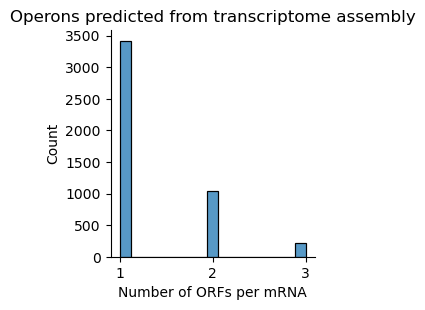

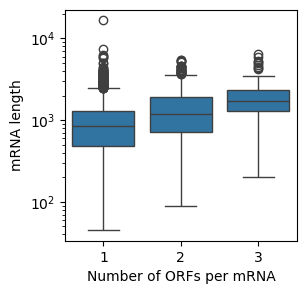

In [7]:
from riboss.orfs import operon_finder
import pyranges as pr
import pandas as pd

bed =  '../ref/metatranscriptome/metagenome.bed'
outdir =  '../results/styphimurium/operon_finder'
tx_assembly =  '../doc/metatranscriptome/lt2.fa'
delim = '::'

cdstx_, cds_range, df = operon_finder(tx_assembly, bed, outdir, delim, log=True)

In [8]:
# calculate genes per operon
cdstx_.df.shape[0]/cdstx_.tid.unique().shape[0]

1.3138514236780132

In [9]:
# calculate genes per transcript
cdstx_.df.value_counts(['tid','length']).reset_index().value_counts('count')

count
1    3418
2    1040
3     213
Name: count, dtype: int64

In [2]:
1040+213

1253

In [10]:
df.value_counts('ORF_type')

ORF_type
oORF     76020
mORF      4548
sORF      4240
opORF      363
Name: count, dtype: int64

In [11]:
from riboss.orfs import fasta_to_dataframe

d = fasta_to_dataframe( '../doc/metatranscriptome/lt2.fa')
d['length'] = d.seq.apply(lambda x: len(x))
d.describe()

,length
count,4681.000000
mean,1109.977355
std,830.332797
min,45.000000
25%,546.000000
50%,929.000000
75%,1433.000000
max,16680.000000


#### Analyse ribosome footprints

analyse_footprints allows the aligned footprint positions to be adjusted to the P-site, either from the 5' or 3' end through the offset_method. For this data, the 5' offset method produced more consistent triplet periodicity for the footprint sizes 25 nt and 28 nt (see metagene plots).

downsampling BAM       : 8384921it [00:18, 447465.10it/s]
comparing periodicity  : 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 24.00it/s]
INFO:root:saved selected footprint sizes with an offset as ../results/analyse_footprints/ERR9130942Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as ../results/analyse_footprints/ERR9130942Aligned.out.frames.pdf
INFO:root:saved metagene plots as ../results/analyse_footprints/ERR9130942Aligned.out.start_codon.pdf and ../results/analyse_footprints/ERR9130942Aligned.out.stop_codon.pdf
downsampling BAM       : 21975665it [00:42, 511840.40it/s]
comparing periodicity  : 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 23.88it/s]
INFO:root:saved selected footprint sizes with an offset as ../results/analyse_footprints/ERR9130943Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as ../results/analyse_footprints/ERR9130943Aligned.out.frames.pdf
INFO:root:saved metagene plots as ..

    footprint_len  frame  counts
0              25      0   21629
1              25      1   20153
2              25      2   27823
3              26      0   21281
4              26      1   23592
5              26      2   18871
6              27      0   22377
7              27      1   16274
8              27      2   16879
9              28      0   14909
10             28      1   13315
11             28      2   16435
12             29      0   12137
13             29      1   12908
14             29      2   10403
15             30      0   11004
16             30      1    8142
17             30      2    8113
18             31      0    7217
19             31      1    5840
20             31      2    7728
21             32      0    5364
22             32      1    5328
23             32      2    4999
24             33      0    4756
25             33      1    3544
26             33      2    3849
27             34      0    3119
28             34      1    2833
29        

downsampling BAM       : 18199884it [00:22, 815854.20it/s]
comparing periodicity  : 100%|████████████████████████████████████████| 1/1 [00:00<00:00, 23.39it/s]
INFO:root:saved selected footprint sizes with an offset as ../results/analyse_footprints/ERR9130944Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as ../results/analyse_footprints/ERR9130944Aligned.out.frames.pdf
INFO:root:saved metagene plots as ../results/analyse_footprints/ERR9130944Aligned.out.start_codon.pdf and ../results/analyse_footprints/ERR9130944Aligned.out.stop_codon.pdf
downsampling BAM       : 15161885it [00:19, 774899.92it/s]
ERROR:root:Reads are longer than expected! Are you sure that this is a ribosome profiling library? Here are the statistics by reading frame.
Traceback (most recent call last):
  File "/projects/health_sciences/bms/biochemistry/lim_group/riboss/riboss/footprints.py", line 227, in footprint_summary
    if f.shape[0]>0:
       ^^^^^^^
AttributeError: 'NoneType' object has 

    footprint_len  frame  counts
0              25      0    2534
1              25      1    1955
2              25      2    1197
3              26      0    5244
4              26      1    3213
5              26      2    2579
6              27      0    5267
7              27      1    6443
8              27      2    3188
9              28      0    5918
10             28      1    5610
11             28      2    2342
12             29      0    4325
13             29      1    4892
14             29      2    2917
15             30      0    3689
16             30      1    4395
17             30      2    2572
18             31      0    3785
19             31      1    3111
20             31      2    2673
21             32      0    3195
22             32      1    3698
23             32      2    2637
24             33      0    3533
25             33      1    3464
26             33      2    1760
27             34      0    3298
28             34      1    2868
29        

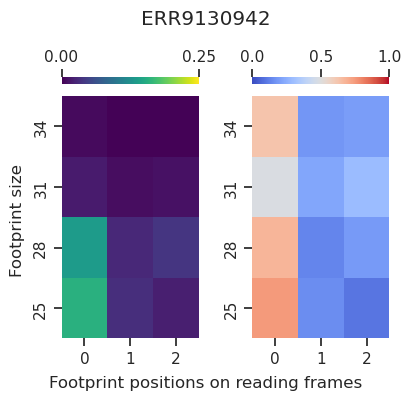

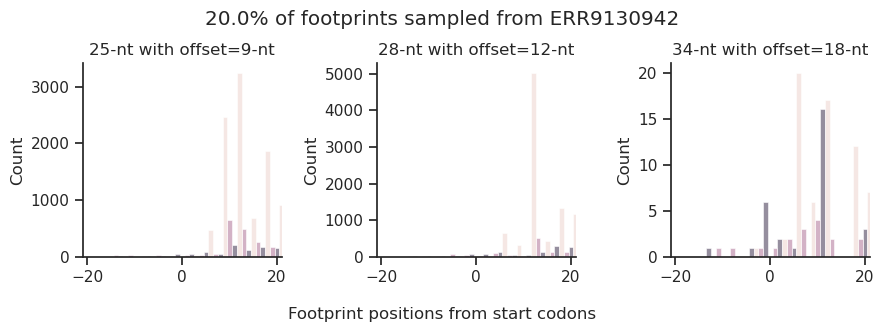

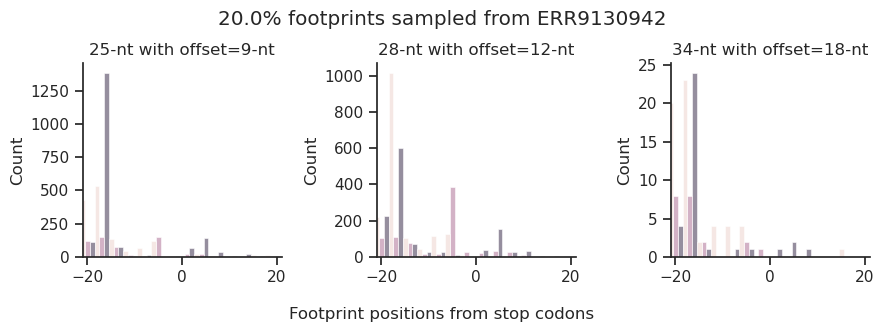

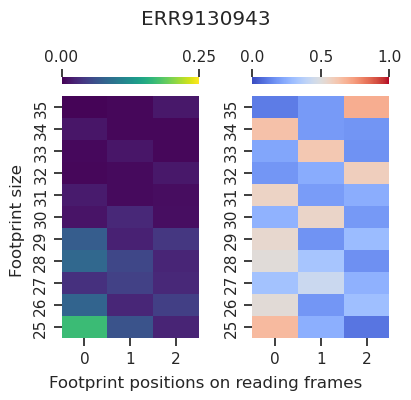

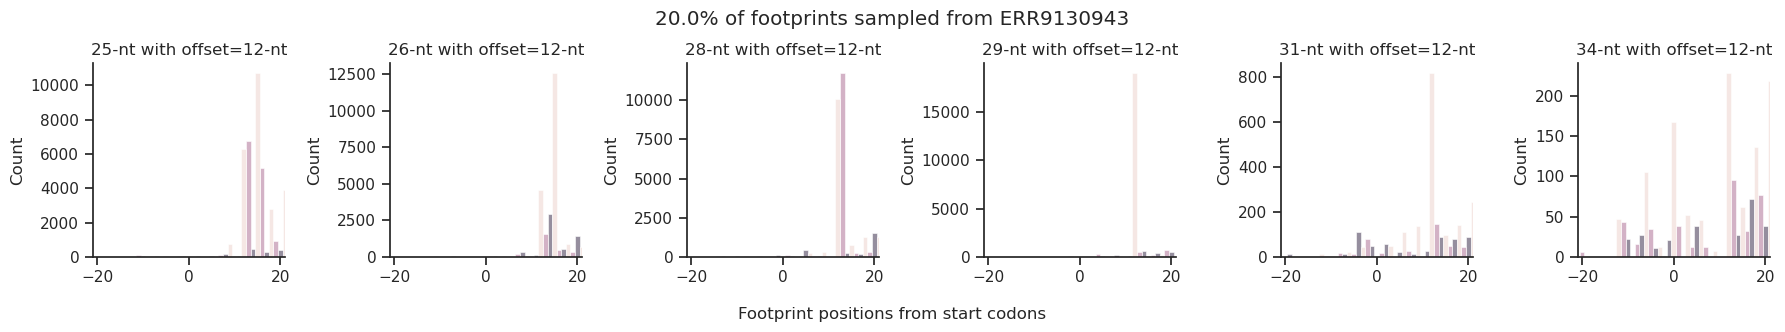

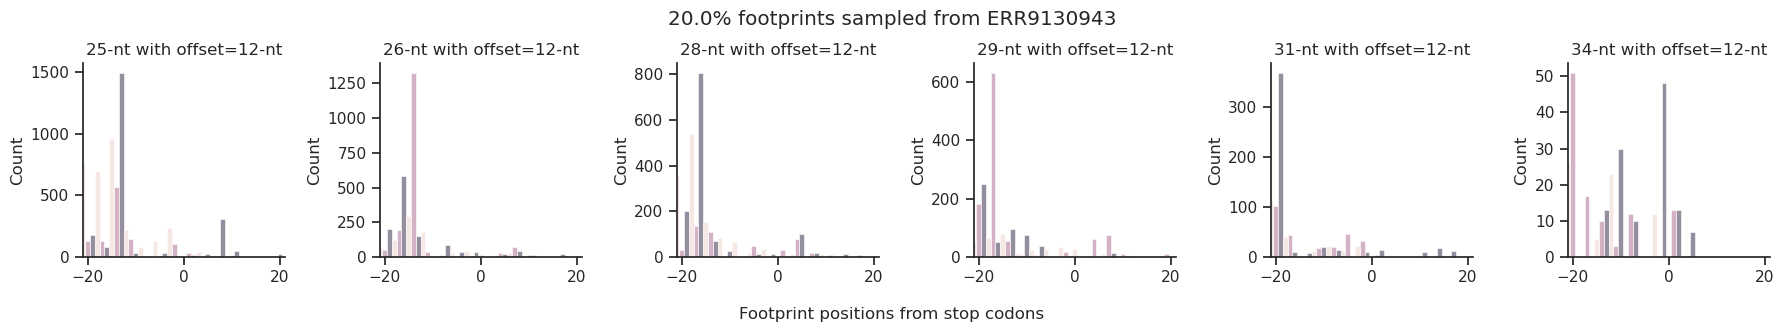

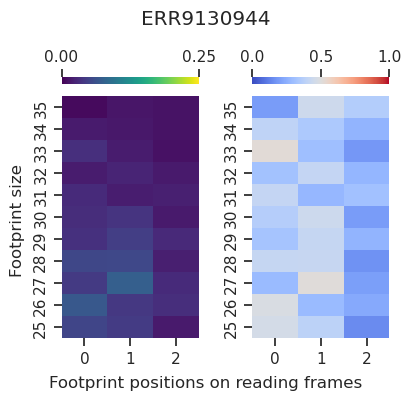

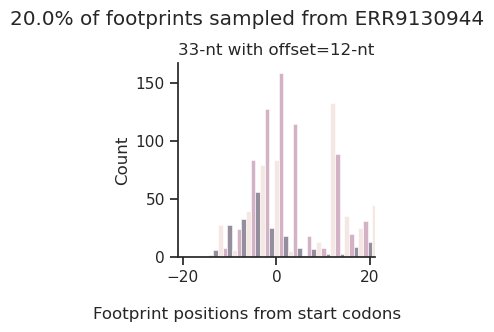

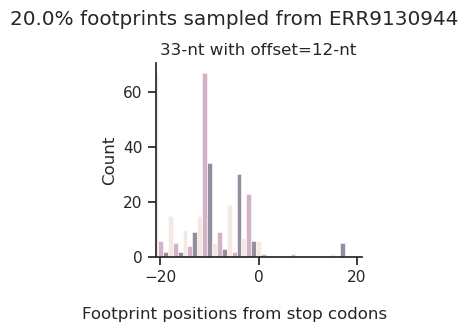

In [1]:
import os
import logging
from glob import glob
from riboss.footprints import analyse_footprints

offset_method = '5p'
adj = 12
downsampling = 0.2
cds_range = '../results/styphimurium/operon_finder/lt2.cds_range.txt'
outdir =  '../results/styphimurium/analyse_footprints'

footprint_stats = []
for i in glob( '../doc/styphimurium/riboseq/*Aligned.out.bam'):
    try:
        stats = analyse_footprints(offset_method, adj, i, downsampling, cds_range, 'good', outdir)
        stats['run'] = os.path.basename(i)
        stats['run'] = stats['run'].str.replace('Aligned.out.bam','')
        footprint_stats.append(stats)
    except Exception as e:
        logging.exception('Expected errors for RNA-seq library.')
        pass

In [2]:
! cat ../results/styphimurium/analyse_footprints/ERR9130942Aligned.out.offset.txt

25	9
28	12
34	18


In [3]:
! cat ../results/styphimurium/analyse_footprints/ERR9130943Aligned.out.offset.txt

25	12
26	12
28	12
29	12
31	12
34	12


In [4]:
import pandas as pd

filereport = pd.read_csv( '../doc/styphimurium/riboseq/filereport_read_run_PRJEB51486_tsv.txt', sep='\t')
filereport[['run_accession','sample_title']]

,run_accession,sample_title
0,ERR9130944,RiboSeq S7 1000U
1,ERR9130945,RiboSeq S7 750U
2,ERR9130942,RiboSeq RNase1 1000U
3,ERR9130943,RiboSeq RNase1 500U
4,ERR9130946,RNA-Seq


#### Merge ribosome profiling data and footprint offset files

In [5]:
! samtools merge \
    ../doc/styphimurium/riboseq/ERR9130942Aligned.out.bam \
    ../doc/styphimurium/riboseq/ERR9130943Aligned.out.bam \
    -f -o ../doc/styphimurium/riboseq/ERR9130942_3.bam

#### Build salmon index using transcriptome assembly and run salmon quant

In [1]:
from riboss.wrapper import quantify_transcripts

index_prefix =  '../doc/metatranscriptome/lt2'
tx_assembly =  '../doc/metatranscriptome/lt2.fa'
rnaseq =  '../doc/styphimurium/riboseq/ERR9130946.fastq.gz'
outdir = '../doc/styphimurium/riboseq/'

quantify_transcripts(rnaseq, tx_assembly, index_prefix=index_prefix, outdir=outdir)

INFO:root:Index directory ../doc/metatranscriptome/lt2_puff exists.

Version Info: This is the most recent version of salmon.
-----------------------------------------
| Loading contig table | Time = 1.5429 ms
-----------------------------------------
size = 5862
-----------------------------------------
| Loading contig offsets | Time = 951.91 us
-----------------------------------------
-----------------------------------------
| Loading reference lengths | Time = 11.612 us
-----------------------------------------
-----------------------------------------
| Loading mphf table | Time = 3.3736 ms
-----------------------------------------
size = 4369872
Number of ones: 5861
Number of ones per inventory item: 512
Inventory entries filled: 12
-----------------------------------------
| Loading contig boundaries | Time = 7.0823 ms
-----------------------------------------
size = 4369872
-----------------------------------------
| Loading sequence | Time = 1.3694 ms
-----------------------

'../doc/styphimurium/riboseq/ERR9130946_salmon_quant/'

#### Assign footprints to transcripts using riboprof (ribomap)

In [1]:
from riboss.wrapper import riboprofiler

offset =  '../results/styphimurium/analyse_footprints/ERR9130942Aligned.out.offset.txt'
ribobam =  '../doc/styphimurium/riboseq/ERR9130942_3.bam'
mrnabam =  '../doc/styphimurium/riboseq/ERR9130946Aligned.out.bam'
tx_assembly =  '../doc/metatranscriptome/lt2.fa'
sf =  '../doc/styphimurium/riboseq/ERR9130946_salmon_quant/quant.sf'
out =  '../results/styphimurium/riboprofiler/ERR9130942_3'
cds_range_file =  '../results/styphimurium/operon_finder/lt2.cds_range.txt'

riboprof_base = riboprofiler(offset, ribobam, mrnabam, 
                             tx_assembly, cds_range_file, 
                             sf, out)

getting transcript info...
total number of transcripts in transcriptome: 4681
assigning ribo-seq reads...
constructing profile class...
number of transcripts in profile class: 3892
loading reads from bam...
getting readlen mapping to P site offset...
getting alignment records...
total number of reads: 16241294
getting read type and p-sites...
total output footprint: 16241294
total: 16241294	multi_mapped: 743106 (4.58 %)
assigning reads to frame 0 loci...
reads used: 4473577 reads assigned: 4473577
assigning reads to frame 1 and 2 loci...
reads used: 6630713 reads assigned: 6630713
assigning reads to UTR loci...
reads used: 6752218 reads assigned: 6752218
assigning RNA-seq reads...
number of transcripts in profile class: 3892
loading reads from bam...
getting alignment records...
total number of reads: 17311488
getting read type and p-sites...
total output footprint: 17311488
total: 17311488	multi_mapped: 1531365 (8.85 %)
assigning reads...
reads used: 17311488 reads assigned: 17311488


INFO:root:saved main output as ../results/riboprofiler/ERR9130942_3.base


#### Find new ORFs using the main RIBOSS function

parsing ribomap output : 100%|████████████████████████████████| 3.83k/3.83k [00:00<00:00, 10.4kit/s]
parsing ribomap output : 100%|████████████████████████████████| 3.83k/3.83k [00:00<00:00, 8.04kit/s]
INFO:root:saved ribosome profiles as ../results/riboss/ERR9130942_3.riboprof.plus.bg and ../results/riboss/ERR9130942_3.riboprof.minus.bg
counting footprints    : 100%|█████████████████████████████████| 72.8k/72.8k [00:00<00:00, 118kit/s]
comparing periodicity  : 100%|██████████████████████████████████| 1853/1853 [01:18<00:00, 23.70it/s]
INFO:root:saved RIBOSS stats as ../results/riboss/ERR9130942_3.riboss.boss.pkl and ../results/riboss/ERR9130942_3.riboss.boss.csv
INFO:root:saved significant RIBOSS results (n=623) as ../results/riboss/ERR9130942_3.riboss.sig.pkl
--2025-02-17 15:47:54--  https://genome.ucsc.edu/goldenpath/help/examples/bigGenePred.as
Resolving genome.ucsc.edu (genome.ucsc.edu)... 128.114.119.131, 128.114.119.132
Connecting to genome.ucsc.edu (genome.ucsc.edu)|128.114.119

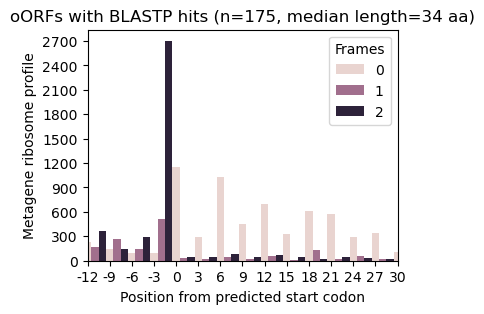

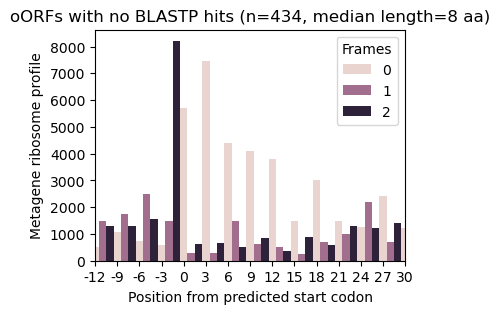

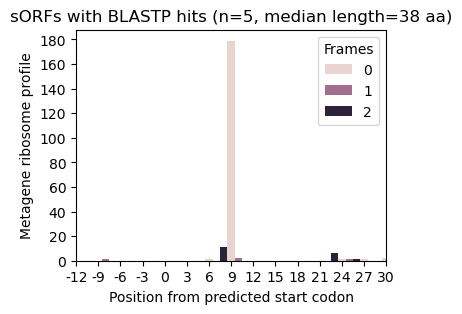

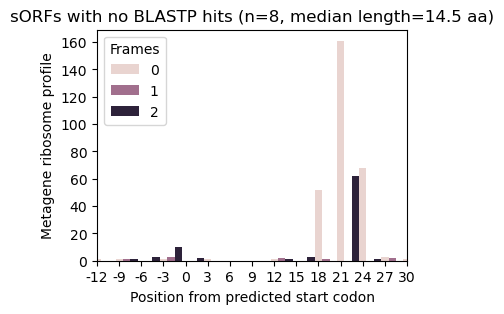

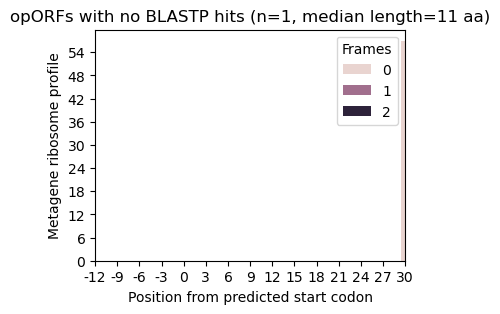

In [1]:
from riboss.riboss import riboss
import pandas as pd

superkingdom='Bacteria'
tx_assembly =  '../doc/metatranscriptome/lt2.fa'
fasta =  '../ref/styphimurium/GCF_000006945.2_ASM694v2_genomic.fna.gz'
riboprof_base =  '../results/styphimurium/riboprofiler/ERR9130942_3.base'
profile='ribo'
bed =  '../ref/metatranscriptome/metagenome.bed'
outdir =  '../results/styphimurium/riboss'
padj_method = 'fdr_bh'
tie = True #False
num_simulations = 1000
email='chunshen.lim@otago.ac.nz'
api_key='55890b8dfafe4d49e57c5f1d031aec4c2509'
df = pd.read_pickle('../results/styphimurium/operon_finder/lt2.operon_finder.pkl.gz')

boss_df, sig, blast, tophits, ipg = riboss(superkingdom, df, riboprof_base, profile, fasta, tx_assembly, bed,
                                           padj_method='fdr_bh', tie=tie, num_simulations=num_simulations, 
                                           run_blastp=True, run_efetch=True, verbose=True,
                                           email=email, api_key=api_key, delim='::', outdir=outdir)

#### Visit the [_S_. Typhimurium LT2 genome](https://genome.ucsc.edu/h/GCF_000006945.2) at the UCSC Genome Browser
Click "Manage custom tracks" and submit the tracks below using "Paste URLs or Data".

1. BigGenePred annotation track for predicted sORFs:
```
track type=bigGenePred name="sORFs" description="RIBOSS top hits" baseColorDefault=genomicCodons bigDataUrl=https://github.com/lcscs12345/riboss/raw/refs/heads/master/results/riboss/ERR9130942_3.riboss.sORF.tophits.bb
```

2. BedGraph for ribosome profiles:
```
https://raw.githubusercontent.com/lcscs12345/riboss/refs/heads/master/results/riboss/ERR9130942_3.riboprof.bg
```

3. BED annotation track for transcriptome assembly:
```
https://github.com/lcscs12345/riboss/raw/refs/heads/master/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bed
```